In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2 as cv2
from skimage.filters.rank import entropy
from skimage.morphology import disk
from skimage.filters import gaussian, sobel, scharr
from skimage.feature import canny
from scipy import ndimage
import random
import tensorflow as tf
from tensorflow.keras import utils
import pandas as pd
import seaborn as sns
import pickle


%matplotlib inline


In [49]:
def create_data_files(directory, array, type=None):
    '''this function reads the images from the directory and create training & testing datasets'''
    i = 0
    for category in categories:
        path = os.path.join(directory, category)  # path to directory of images
        class_num = categories.index(category)  # assign number to the 5 categories
        img_list = os.listdir(path)

        if type == 'aspect':
            for img in img_list:
                try:
                    img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)  # read in Grayscale
                    img_array = crop_and_resize(img_array)  # crop & resize maintaining aspect ratio
                    array.append([img_array, class_num])
                    i += 1
                except Exception as e:
                    print(f'Error: \n category: {category}\n image: {img}\n reason: {e}')
                    continue  # Skip the problematic image

        elif type == 'gray':
            for img in img_list:
                try:
                    img_array = cv2.imread(os.path.join(path, img))
                    face_array = extract_face(img_array)  # extract face
                    gray_array = cv2.cvtColor(face_array, cv2.COLOR_BGR2GRAY)  # convert to Gray
                    array.append([gray_array, class_num])  # 0=image, 1=class
                    i += 1
                except Exception as e:
                    print(f'Error: \n category: {category}\n image: {img}\n reason: {e}')
                    continue  # Skip the problematic image

        elif type == 'rgb':
            for img in img_list:
                try:
                    img_array = cv2.imread(os.path.join(path, img))
                    face_array = extract_face(img_array)  # extract face
                    rgb_array = cv2.cvtColor(face_array, cv2.COLOR_BGR2RGB)  # convert to RGB
                    array.append([rgb_array, class_num])  # 0=image, 1=class
                    i += 1
                except Exception as e:
                    print(f'Error: \n category: {category}\n image: {img}\n reason: {e}')
                    continue  # Skip the problematic image

        else:
            print("Please specify image type ['aspect', 'gray', 'rgb']")
            break

        # Print progress every 200 images
        if i % 200 == 0:
            print(f"Images processed: {i} of {len(img_list) * len(categories)}")
    
    print(f"Finished processing images. Total processed: {i}")


In [3]:
def show_img(num, img_array, title, ncols=1):
    '''this function display images from an image array'''
    ncols= ncols
    nrows= int(num/ncols)
    fig, ax = plt.subplots(nrows, ncols, figsize =(ncols*4,nrows*4))
    fig.suptitle(title, size = 20)
    ax = ax.ravel()
    for i in range(num):
        ax[i].imshow(img_array[i][0], cmap='gray')
        ax[i].set_title(label_map.get(img_array[i][1]), size=16)

In [4]:

# print summaries:
def print_summary(train_array, test_array):
    print(f'\nTraining Dataset:\n')
    print(f'Shape: {train_array.shape}')
    print(f'Classes: {np.unique(train_array[:,1])}')
    print(f'No. of Images in each class: {np.bincount(train_array[:,1].astype(int))}')
    print(f'Max Pixels: {np.amax(train_array[0][0][:])}')
    print('\n--------------------------------------\n')
    print(f'\nTesting Dataset:\n')
    print(f'Shape: {test_array.shape}')
    print(f'Classes: {np.unique(test_array[:,1])}')
    print(f'No. of Images in each class: {np.bincount(test_array[:,1].astype(int))}')
    print(f'Max Pixels: {np.amax(test_array[0][0][:])}')
    print('\n--------------------------------------\n')


In [5]:
# print summaries:
def print_summary(train_array, test_array):
    print(f'\nTraining Dataset:\n')
    print(f'Shape: {train_array.shape}')
    print(f'Classes: {np.unique(train_array[:,1])}')
    print(f'No. of Images in each class: {np.bincount(train_array[:,1].astype(int))}')
    print(f'Max Pixels: {np.amax(train_array[0][0][:])}')
    print('\n--------------------------------------\n')
    print(f'\nTesting Dataset:\n')
    print(f'Shape: {test_array.shape}')
    print(f'Classes: {np.unique(test_array[:,1])}')
    print(f'No. of Images in each class: {np.bincount(test_array[:,1].astype(int))}')
    print(f'Max Pixels: {np.amax(test_array[0][0][:])}')
    print('\n--------------------------------------\n')

In [6]:
def train_test_prep(training_data_array, testing_data_array):

    # shuffle the images to mix all the 5 classes randomly
    random.shuffle(training_data_array)
    random.shuffle(testing_data_array)

    # read and split X_train, X_test, y_train, y_test into an array
    X_train = []
    y_train = []
    X_test = []
    y_test = []

    for features, label in training_data_array:
        X_train.append(features)
        y_train.append(label)

    for features, label in testing_data_array:
        X_test.append(features)
        y_test.append(label)

    # change data types/format for X
    X_train = np.array(X_train, dtype=float)
    X_test = np.array(X_test, dtype=float)

    X_train = X_train/255
    X_test = X_test/255

    # change values of y to categorical
    y_train = utils.to_categorical(y_train, 5)
    y_test = utils.to_categorical(y_test, 5)

    return(X_train, X_test, y_train, y_test)

In [7]:
def pickle_out(X_train, X_test, y_train, y_test, version):
    '''To save the data out for modelling'''
    
    # Tentukan path tempat menyimpan file
    data_path = 'C:/Users/whisn/FaceShape Dataset/data/'

    # Periksa apakah folder data ada, jika tidak buat
    if not os.path.exists(data_path):
        os.makedirs(data_path)

    # Simpan X_train
    name_xtn = data_path + 'X_train_' + version + '.pickle'
    with open(name_xtn, "wb") as pickle_file:
        pickle.dump(X_train, pickle_file)

    # Simpan y_train
    name_ytn = data_path + 'y_train_' + version + '.pickle'
    with open(name_ytn, "wb") as pickle_file:
        pickle.dump(y_train, pickle_file)

    # Simpan X_test
    name_xts = data_path + 'X_test_' + version + '.pickle'
    with open(name_xts, "wb") as pickle_file:
        pickle.dump(X_test, pickle_file)

    # Simpan y_test
    name_yts = data_path + 'y_test_' + version + '.pickle'
    with open(name_yts, "wb") as pickle_file:
        pickle.dump(y_test, pickle_file)

    print(f"Data saved with version '{version}'")


In [8]:
# Assign the drives for image data, and specify the classes / labels
train_dir = 'C:/Users/whisn/FaceShape Dataset/training_set'
test_dir = 'C:/Users/whisn/FaceShape Dataset/testing_set'
categories = ['Heart','Oblong','Oval','Round','Square']
label_map = {0:'Heart', 1: 'Oblong', 2: 'Oval', 3: 'Round', 4: 'Square'}

In [9]:
# create path to images in examples

ex_path = 'C:/Users/whisn/FaceShape Dataset/examples'
ex_files = os.listdir(ex_path)

examples = []

for i in ex_files:
    img = os.path.join(ex_path,i)
    examples.append(img)

examples = sorted(examples)
examples

['C:/Users/whisn/FaceShape Dataset/examples\\heart (7).jpg',
 'C:/Users/whisn/FaceShape Dataset/examples\\landscape.jpg',
 'C:/Users/whisn/FaceShape Dataset/examples\\oblong (7).jpg',
 'C:/Users/whisn/FaceShape Dataset/examples\\oval (1).jpg',
 'C:/Users/whisn/FaceShape Dataset/examples\\portrait.jpg',
 'C:/Users/whisn/FaceShape Dataset/examples\\round (1).JPG',
 'C:/Users/whisn/FaceShape Dataset/examples\\square (1).jpg']

In [10]:
# Let's define a function to resize image by maintaing aspect ratio, but some parts of image will need to be cropped out

def crop_and_resize(image, target_w=224, target_h=224):
    '''this function crop & resize images to target size by keeping aspect ratio'''
    if image.ndim == 2:
        img_h, img_w = image.shape             # for Grayscale will be   img_h, img_w = img.shape
    elif image.ndim == 3:
        img_h, img_w, channels = image.shape   # for RGB will be   img_h, img_w, channels = img.shape
    target_aspect_ratio = target_w/target_h
    input_aspect_ratio = img_w/img_h

    if input_aspect_ratio > target_aspect_ratio:
        resize_w = int(input_aspect_ratio*target_h)
        resize_h = target_h
        img = cv2.resize(image, (resize_w , resize_h))
        crop_left = int((resize_w - target_w)/2)  ## crop left/right equally
        crop_right = crop_left + target_w
        new_img = img[:, crop_left:crop_right]
    if input_aspect_ratio < target_aspect_ratio:
        resize_w = target_w
        resize_h = int(target_w/input_aspect_ratio)
        img = cv2.resize(image, (resize_w , resize_h))
        crop_top = int((resize_h - target_h)/4)   ## crop the top by 1/4 and bottom by 3/4 -- can be changed
        crop_bottom = crop_top + target_h
        new_img = img[crop_top:crop_bottom, :]
    if input_aspect_ratio == target_aspect_ratio:
        new_img = cv2.resize(image, (target_w, target_h))

    return new_img

In [11]:
portrait = cv2.imread(
    'C:/Users/whisn/FaceShape Dataset/examples/portrait.jpg',
    cv2.IMREAD_GRAYSCALE)
landscape = cv2.imread(
    'C:/Users/whisn/FaceShape Dataset/examples/landscape.jpg',
    cv2.IMREAD_GRAYSCALE)

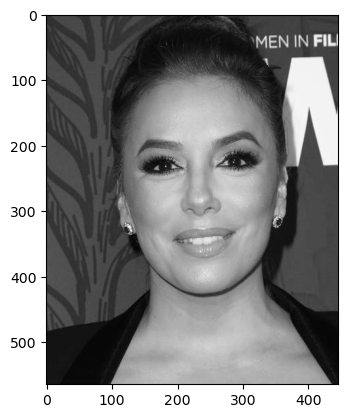

In [12]:
# original image
plt.imshow(portrait,cmap='gray');

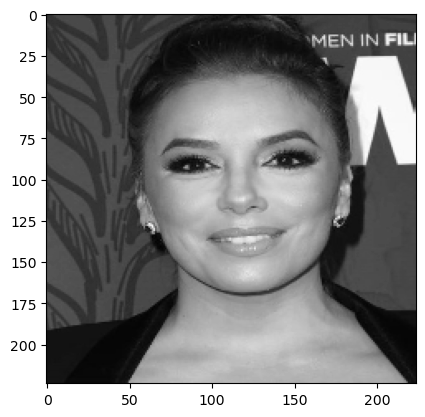

In [13]:
# auto resize by 224 - will be distorted
resized_ptrt = cv2.resize(portrait,(224,224))
plt.imshow(resized_ptrt, cmap='gray')

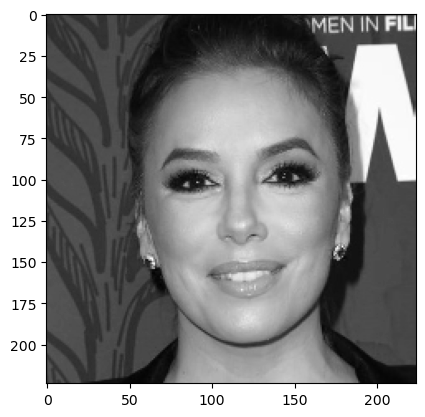

In [14]:
# test if the function works on portrait photos
new_ptrt = crop_and_resize(portrait)
plt.imshow(new_ptrt,cmap='gray');

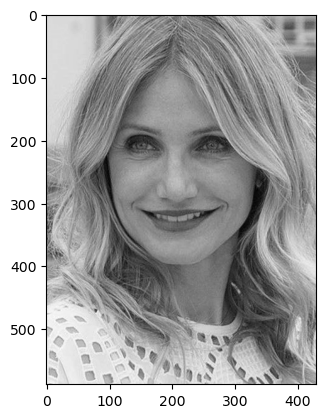

In [15]:
# original image
plt.imshow(landscape,cmap='gray');

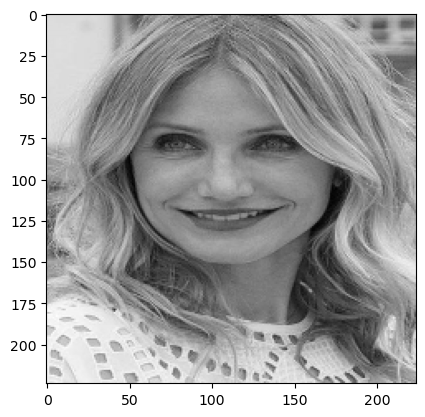

In [16]:
# auto resize by 224 - will be distorted
resized_lscp = cv2.resize(landscape,(224,224))
plt.imshow(resized_lscp, cmap='gray')

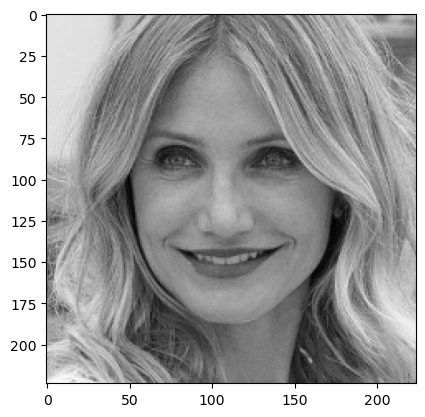

In [17]:
# test if the function works on landscape photos
new_lscp = crop_and_resize(landscape)
plt.imshow(new_lscp,cmap='gray');

In [21]:
!pip install mtcnn
import mtcnn
from mtcnn.mtcnn import MTCNN

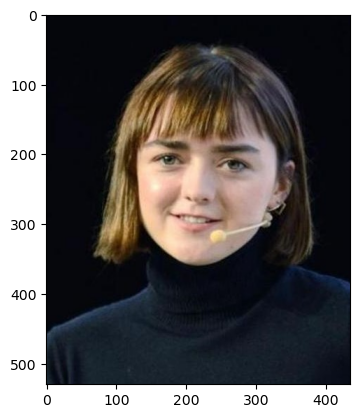

In [22]:
img = cv2.imread('C:/Users/whisn/FaceShape Dataset/examples/round (1).JPG')
img2 = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img2);

In [23]:
# creates detector
detector = MTCNN()
# detect faces in an image
results = detector.detect_faces(img2)
results

[{'box': [134, 120, 184, 227],
  'confidence': 0.9995391368865967,
  'keypoints': {'nose': [216, 259],
   'mouth_right': [253, 294],
   'right_eye': [267, 214],
   'left_eye': [179, 207],
   'mouth_left': [176, 285]}}]

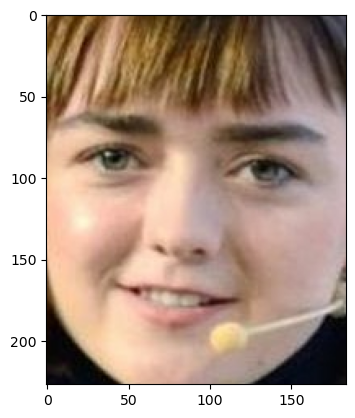

In [24]:
# extract the bounding box from the face

x1, y1, width, height = results[0]['box']
x2, y2 = x1+width, y1+height

face = img2[y1:y2, x1:x2]
plt.imshow(face);

x1 = 134
x2 = 318
y1 = 120
y2 = 347


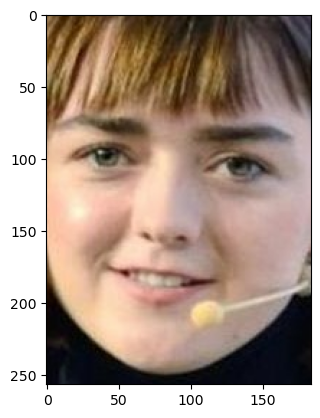

In [25]:
print(f'x1 = {x1}')
print(f'x2 = {x2}')
print(f'y1 = {y1}')
print(f'y2 = {y2}')

# first fix the heights by adding 10 pix each side
face_2 = img2[y1-10:y2+20, x1:x2];
plt.imshow(face_2);

h=257
w=184


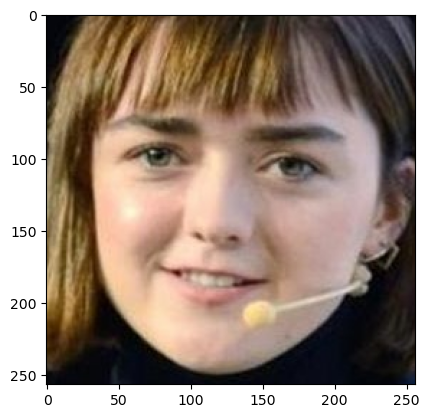

In [26]:
# then add the width to be square
h = (y2+20) - (y1-10)
w = x2-x1
print(f'h={h}')
print(f'w={w}')

adj_h = 10
adj_w = int((h-w)/2)

new_y1 = y1-adj_h
new_y2 = y2+(adj_h*2)

new_x1 = x1-adj_w
new_x2 = x2+adj_w

new_face = img2[new_y1:new_y2, new_x1:new_x2]
plt.imshow(new_face);

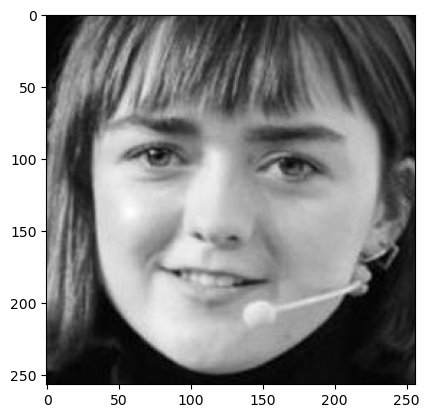

In [27]:
gray = cv2.cvtColor(new_face,cv2.COLOR_RGB2GRAY)
plt.imshow(gray,cmap='gray');

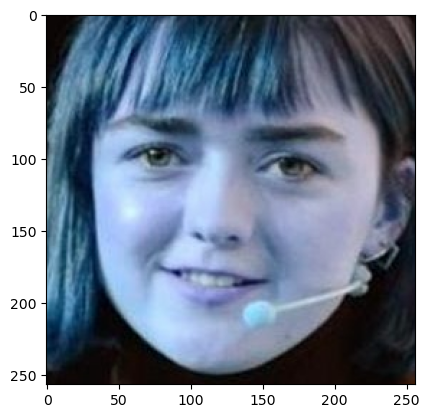

In [28]:
bgr = cv2.cvtColor(new_face,cv2.COLOR_RGB2BGR)
plt.imshow(bgr);

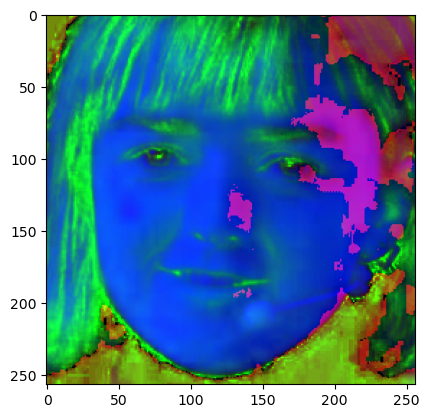

In [29]:
hsv = cv2.cvtColor(new_face,cv2.COLOR_RGB2HSV)
plt.imshow(hsv,cmap='gray');

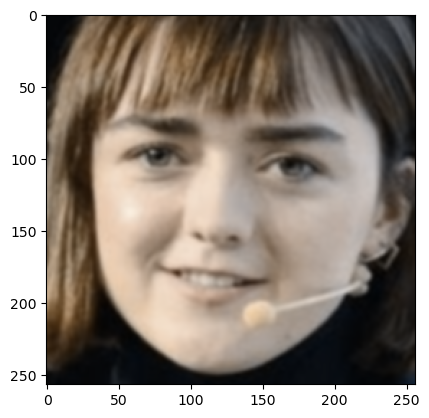

In [30]:
blur = gaussian(new_face)
plt.imshow(blur);

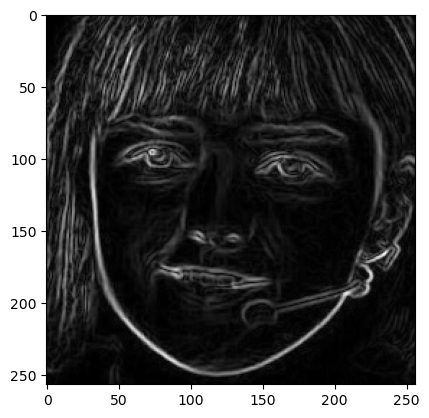

In [31]:
scharr_img = scharr(gray)

plt.imshow(scharr_img, cmap='gray');

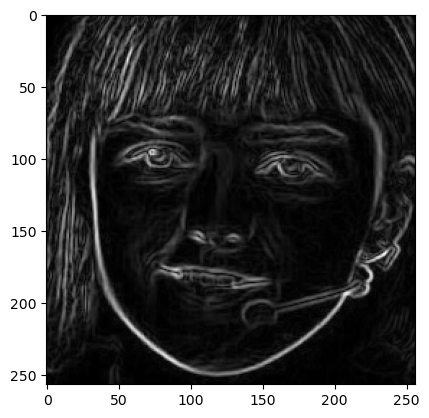

In [32]:
sobel_img = sobel(gray)
plt.imshow(sobel_img, cmap='gray');

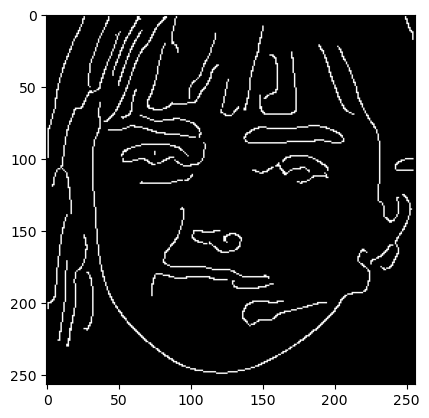

In [33]:
canny_img = canny(gray, sigma = 3)
plt.imshow(canny_img, cmap='gray');

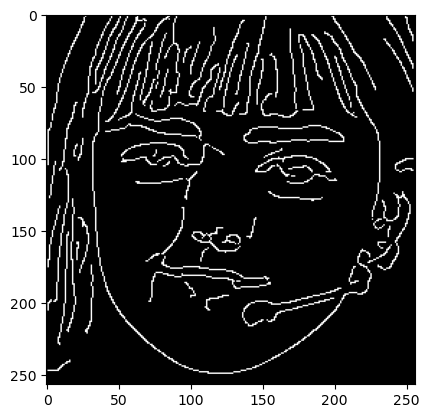

In [34]:
canny_img = canny(gray, sigma = 2)
plt.imshow(canny_img, cmap='gray');

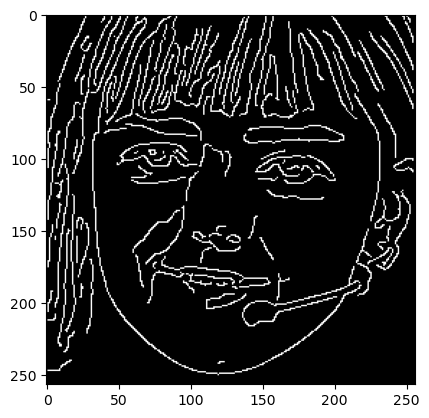

In [35]:
canny_img = canny(gray, sigma = 1.5)
plt.imshow(canny_img, cmap='gray');

In [36]:
def cvt_gabor(gray_img):
    ksize = 3
    sigma = 0.5
    theta = 1*np.pi/4
    lamda = 1*np.pi/4
    gamma = 0.8
    phi = 0

    gabor_kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamda, gamma, phi, ktype=cv2.CV_32F)
    gb_img = cv2.filter2D(gray_img, cv2.CV_8UC3, gabor_kernel)

    return(gb_img)


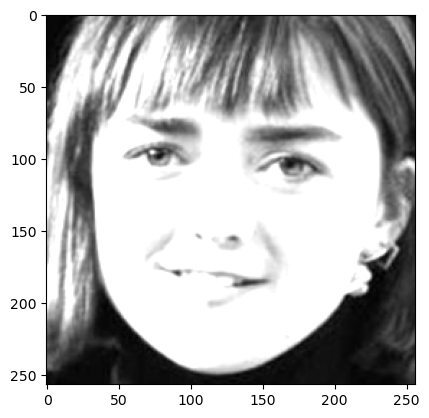

In [37]:
gabor_test = cvt_gabor(gray)
plt.imshow(gabor_test,cmap='gray');

In [38]:
# detector = MTCNN()  # creates detector

def extract_face(img, target_size=(224,224)):
    '''this functions extract face from different images by
    1) finds the facial bounding box
    2) slightly expands top & bottom boundaries to include the whole face
    3) crop into a square shape
    4) resize to target image size for modelling'''

    # 1. detect faces in an image

    results = detector.detect_faces(img)
    if results == []:
        new_face = crop_and_resize(img, target_w=224, target_h=224)
    else:
        x1, y1, width, height = results[0]['box']
        x2, y2 = x1+width, y1+height
        face = img[y1:y2, x1:x2]  # this is the face image from the bounding box before expanding bbox

        # 2. expand the top & bottom of bounding box by 10 pixels to ensure it captures the whole face
        adj_h = 10

        #assign value of new y1
        if y1-adj_h <10:
            new_y1=0
        else:
            new_y1 = y1-adj_h

        #assign value of new y2
        if y1+height+adj_h < img.shape[0]:
            new_y2 = y1+height+adj_h
        else:
            new_y2 = img.shape[0]
        new_height = new_y2 - new_y1

        # 3. crop the image to a square image by setting the width = new_height and expand the box to new width
        adj_w = int((new_height-width)/2)

        #assign value of new x1
        if x1-adj_w < 0:
            new_x1=0
        else:
            new_x1 = x1-adj_w

        #assign value of new x2
        if x2+adj_w > img.shape[1]:
            new_x2 = img.shape[1]
        else:
            new_x2 = x2+adj_w
        new_face = img[new_y1:new_y2, new_x1:new_x2]  # face-cropped square image based on original resolution

    # 4. resize image to the target pixel size
    sqr_img = cv2.resize(new_face, target_size)
    return sqr_img

In [39]:
examples_dir = "C:/Users/whisn/FaceShape Dataset/examples"
examples = [os.path.join(examples_dir, f) for f in os.listdir(examples_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]

print(f"Found {len(examples)} images in examples directory.")

Found 6 images in examples directory.


In [40]:
print("Files in directory:")
print(os.listdir(examples_dir))

Files in directory:
['heart (7).jpg', 'landscape.jpg', 'oblong (7).jpg', 'oval (1).jpg', 'portrait.jpg', 'round (1).JPG', 'square (1).jpg']


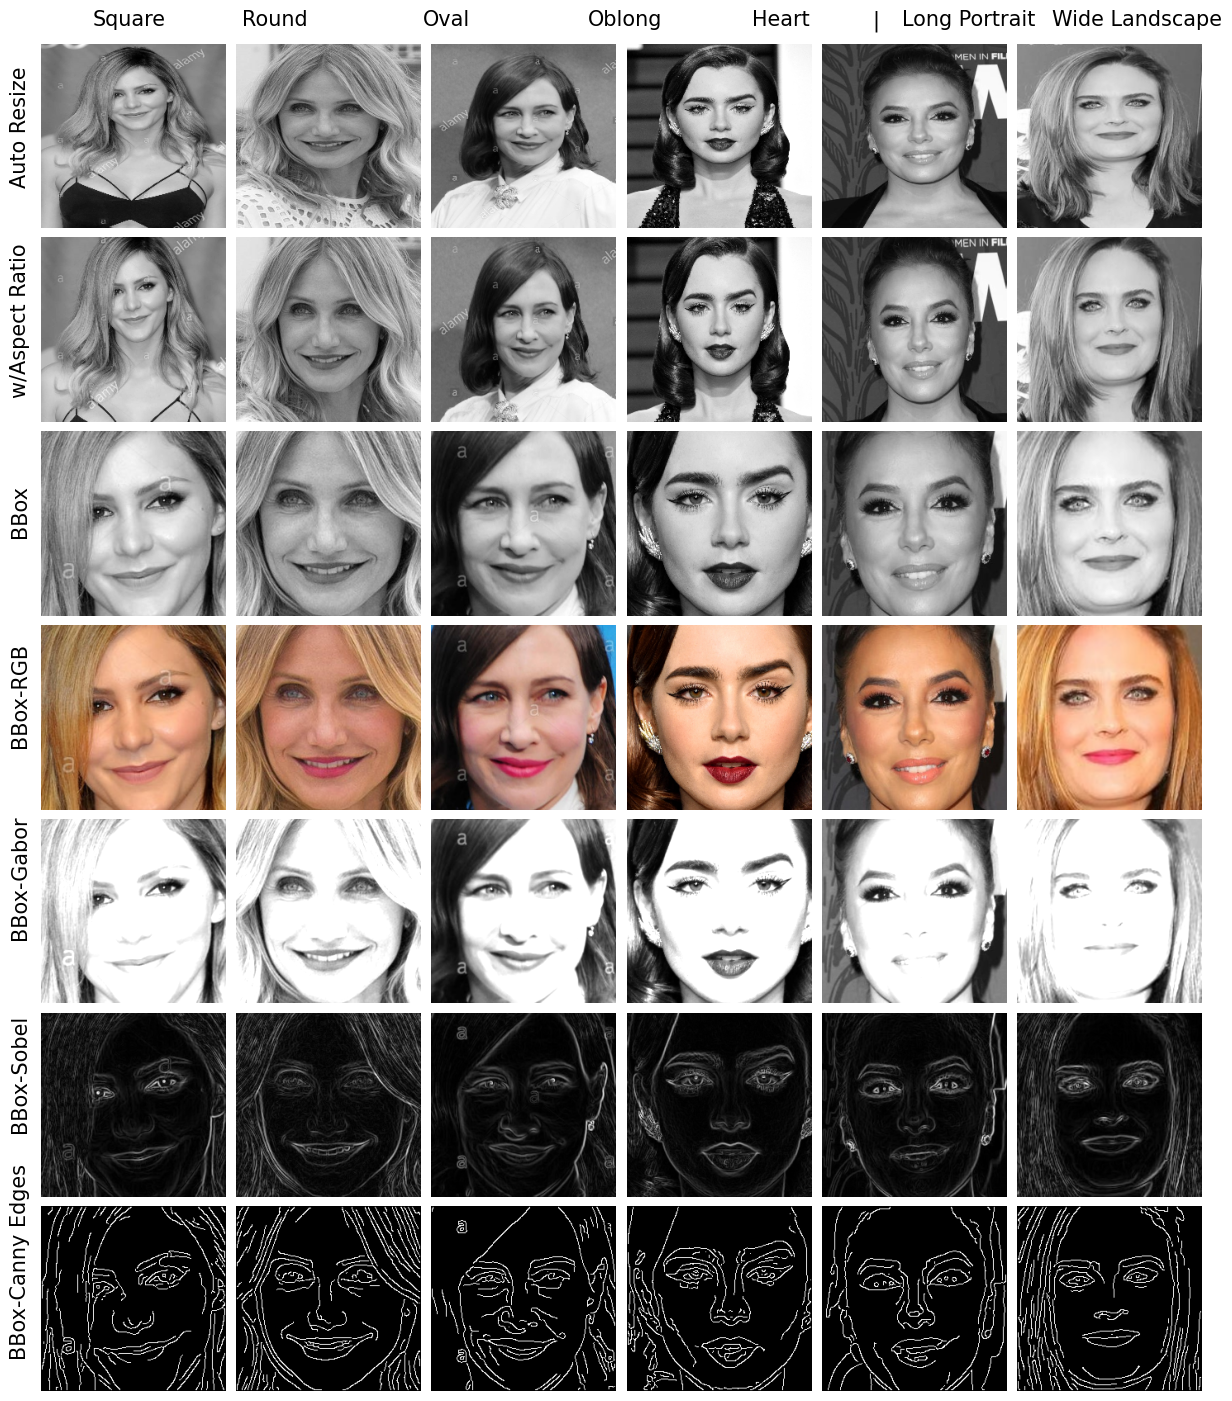

In [41]:
# test the function on the examples

n_images = len(examples)

fig, ax = plt.subplots(nrows=7, ncols=n_images, figsize=(n_images*2.5, (7*2.5)))
plt.gray()

ax= ax.ravel()

for i, file in enumerate(examples):

    img = cv2.imread(file)
    new_img = extract_face(img) # call function to extract face

    rsz_img = cv2.resize(img,(224,224))
    rsz_img = cv2.cvtColor(rsz_img,cv2.COLOR_BGR2GRAY)
    ax[i].imshow(rsz_img)
    ax[i].axis('off')

    aspct_img = crop_and_resize(img, target_w=224, target_h=224)
    aspct_img = cv2.cvtColor(aspct_img,cv2.COLOR_BGR2GRAY)
    ax[i+(n_images*1)].imshow(aspct_img)
    ax[i+(n_images*1)].axis('off')

    rgb_img = cv2.cvtColor(new_img,cv2.COLOR_BGR2RGB)
    ax[i+(n_images*3)].imshow(rgb_img)
    ax[i+(n_images*3)].axis('off')

    gray_img = cv2.cvtColor(new_img,cv2.COLOR_BGR2GRAY)
    ax[i+(n_images*2)].imshow(gray_img)
    ax[i+(n_images*2)].axis('off')

    gabor_img = cvt_gabor(gray_img)
    ax[i+(n_images*4)].imshow(gabor_img)
    ax[i+(n_images*4)].axis('off')

    sobel_img = sobel(gray_img)
    ax[i+(n_images*5)].imshow(sobel_img)
    ax[i+(n_images*5)].axis('off')

    canny_img = canny(gray_img, sigma=1.5)
    ax[i+(n_images*6)].imshow(canny_img)
    ax[i+(n_images*6)].axis('off')

plt.subplots_adjust(hspace=0.05, wspace=0.05)

plt.figtext(x=0.105, y=0.8, s="Auto Resize", fontsize=15, rotation=90)
plt.figtext(x=0.105, y=0.68, s="w/Aspect Ratio", fontsize=15, rotation=90)
plt.figtext(x=0.105, y=0.6, s="BBox", fontsize=15, rotation=90)
plt.figtext(x=0.105, y=0.48, s="BBox-RGB", fontsize=15, rotation=90)
plt.figtext(x=0.105, y=0.37, s="BBox-Gabor", fontsize=15, rotation=90)
plt.figtext(x=0.105, y=0.26, s="BBox-Sobel", fontsize=15, rotation=90)
plt.figtext(x=0.105, y=0.13, s="BBox-Canny Edges", fontsize=15, rotation=90)
plt.figtext(x=0.16, y=0.89, s="Square", fontsize=15)
plt.figtext(x=0.26, y=0.89, s="Round", fontsize=15)
plt.figtext(x=0.38, y=0.89, s="Oval", fontsize=15)
plt.figtext(x=0.49, y=0.89, s="Oblong", fontsize=15)
plt.figtext(x=0.6, y=0.89, s="Heart", fontsize=15)
plt.figtext(x=0.68, y=0.89, s="|", fontsize=15)
plt.figtext(x=0.7, y=0.89, s="Long Portrait", fontsize=15)
plt.figtext(x=0.8, y=0.89, s="Wide Landscape", fontsize=15);


In [42]:
# create new training & testing data with resizing

training_data_apr = []
testing_data_apr = []

create_data_files(train_dir, training_data_apr, 'aspect')
create_data_files(test_dir, testing_data_apr, 'aspect')


Images processed: 800 of 4000
Images processed: 200 of 1000
Images processed: 400 of 1000
Images processed: 600 of 1000
Images processed: 800 of 1000
Images processed: 1000 of 1000


In [43]:
X_train, X_test, y_train, y_test = train_test_prep(training_data_apr, testing_data_apr)

print(f'X_train.shape {X_train.shape}')
print(f'X_test.shape {X_test.shape}')
print(f'y_train.shape {y_train.shape}')
print(f'y_test.shape {y_test.shape}')

X_train.shape (3999, 224, 224)
X_test.shape (1000, 224, 224)
y_train.shape (3999, 5)
y_test.shape (1000, 5)


In [44]:
X_train = np.array(X_train).reshape(-1, 224, 224, 1)
X_test = np.array(X_test).reshape(-1, 224, 224, 1)

print(f'X_train.shape {X_train.shape}')
print(f'X_test.shape {X_test.shape}')
print(f'y_train.shape {y_train.shape}')
print(f'y_test.shape {y_test.shape}')

X_train.shape (3999, 224, 224, 1)
X_test.shape (1000, 224, 224, 1)
y_train.shape (3999, 5)
y_test.shape (1000, 5)


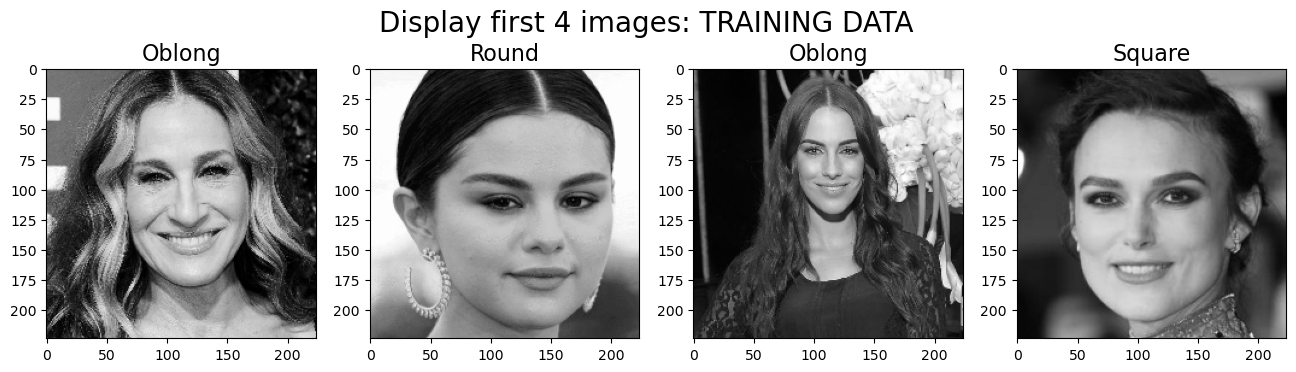

In [45]:
show_img(4, training_data_apr[:4], 'Display first 4 images: TRAINING DATA', ncols=4)

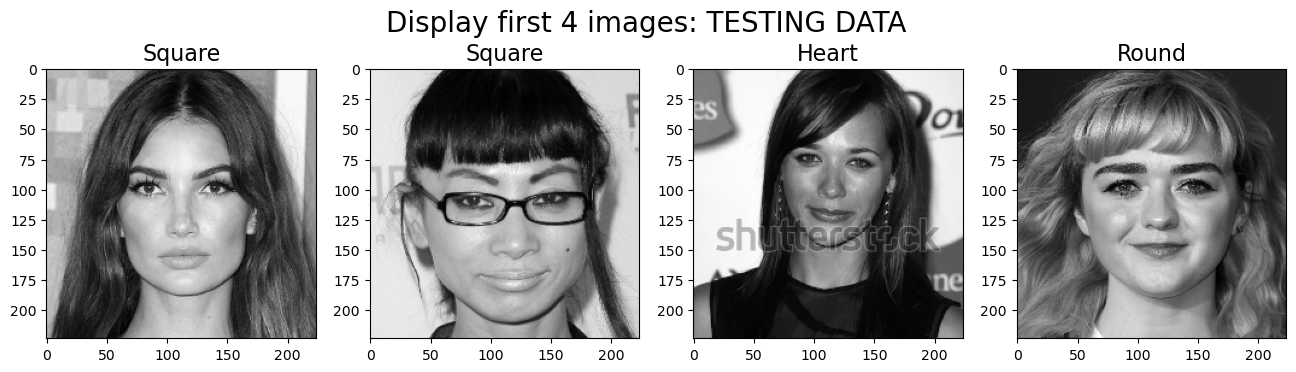

In [46]:
show_img(4, testing_data_apr[:4], 'Display first 4 images: TESTING DATA', ncols=4)

In [47]:
pickle_out(X_train, X_test, y_train, y_test, 'apr')

Data saved with version 'apr'


In [ ]:
training_data_rgb = []
testing_data_rgb = []

create_data_files(train_dir, training_data_rgb, 'rgb')
create_data_files(test_dir, testing_data_rgb, 'rgb')

print(f'Training Images: {len(training_data_rgb)}')
print(f'Testing Images: {len(testing_data_rgb)}')

Images processed: 800 of 4000
Error: 
 category: Oblong
 image: oblong (378).jpg
 reason: Unable to allocate 2.68 GiB for an array with shape (18978, 18978) and data type float64
Error: 
 category: Oblong
 image: oblong (768).jpg
 reason: Unable to allocate 1.49 GiB for an array with shape (14126, 14126) and data type float64


In [69]:
import os

data_path = 'C:/Users/whisn/FaceShape Dataset/data/'
files = os.listdir(data_path)
print(files)  # Menampilkan daftar file yang ada di folder 'data'


['X_test_apr.pickle', 'X_train_apr.pickle', 'y_test_apr.pickle', 'y_train_apr.pickle']


In [71]:
import pickle
import os

# Tentukan path folder yang berisi file pickle
data_path = 'C:/Users/whisn/FaceShape Dataset/data/'

# Daftar nama file pickle yang ingin diperiksa
pickle_files = ['X_test_apr.pickle', 'X_train_apr.pickle', 'y_test_apr.pickle', 'y_train_apr.pickle']

# Memeriksa setiap file pickle
for pickle_file in pickle_files:
    file_path = os.path.join(data_path, pickle_file)
    
    # Membuka dan memuat isi file pickle
    with open(file_path, 'rb') as file:
        data = pickle.load(file)
    
    # Menampilkan tipe data dan bentuk data (jika data berupa array atau matrix)
    print(f"File: {pickle_file}")
    print(f"Type of data: {type(data)}")
    if hasattr(data, 'shape'):
        print(f"Shape of data: {data.shape}")
    
    # Menampilkan sebagian data untuk memastikan isinya
    print(f"Data preview (first 5 items): {data[:5]}\n")


File: X_test_apr.pickle
Type of data: <class 'numpy.ndarray'>
Shape of data: (1000, 224, 224, 1)
Data preview (first 5 items): [[[[0.66666667]
   [0.51372549]
   [0.5372549 ]
   ...
   [0.50588235]
   [0.50588235]
   [0.64313725]]

  [[0.6745098 ]
   [0.52941176]
   [0.54117647]
   ...
   [0.50588235]
   [0.50588235]
   [0.64313725]]

  [[0.68235294]
   [0.54509804]
   [0.54901961]
   ...
   [0.50588235]
   [0.50588235]
   [0.64313725]]

  ...

  [[0.64705882]
   [0.51764706]
   [0.5372549 ]
   ...
   [0.50980392]
   [0.50980392]
   [0.65882353]]

  [[0.67058824]
   [0.51372549]
   [0.53333333]
   ...
   [0.49803922]
   [0.5254902 ]
   [0.65098039]]

  [[0.66666667]
   [0.54901961]
   [0.56862745]
   ...
   [0.50588235]
   [0.51764706]
   [0.65098039]]]


 [[[0.26666667]
   [0.26666667]
   [0.26666667]
   ...
   [0.27843137]
   [0.27843137]
   [0.2745098 ]]

  [[0.27058824]
   [0.26666667]
   [0.2627451 ]
   ...
   [0.27843137]
   [0.2745098 ]
   [0.2745098 ]]

  [[0.26666667]
   [0.26